# Churn Model: Model Pipeline & Training

In this notebook, we define the model pipeline, and train an initial model based on a RandomForestClassifier.

Then, we perform a grid search CV to find the best model, and to it we do hyperparameter tuning.

### Table of contents:
1. Pipeline Definition & Initial Training
2. Grid Search CV & Hyperparameter Tuning

In [22]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Pipeline Definition & Initial Training

In this section, we define the pipeline for both preprocessing and the training. Firsty, we define all the transformers we'll be using, and then combine them into a preprocessor. 

Lastly, we create the pipeline with the model.

In [23]:
clean_df = pd.read_excel("../data/clean_data.xlsx", index_col=0)
clean_df.drop(columns=['CustomerID'], inplace=True)

numerical_columns = ["Tenure", "WarehouseToHome", "HourSpendOnApp", 
                     "NumberOfDeviceRegistered", "SatisfactionScore", 
                     "NumberOfAddress", "OrderAmountHikeFromlastYear", 
                     "CouponUsed", "OrderCount", "DaySinceLastOrder",
                     "CashbackAmount"]

categorical_columns = ["PreferredLoginDevice", "CityTier", 
                       "PreferredPaymentMode", "Gender", "PreferredOrderCat",
                       "MaritalStatus", "Complain"]

##### Preprocessing Pipelines

In [24]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

##### Column Transformer

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

### Initial Training & Results

In [26]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [27]:
y = clean_df['Churn']
X = clean_df.drop(columns=['Churn'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Save train test df for next notebook
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df.to_excel("../data/train_data.xlsx")
test_df.to_excel("../data/test_data.xlsx")

In [28]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'HourSpendOnApp',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'OrderAmountHikeFromlastYear',
                                                   'CouponUsed', 'OrderCount',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['PreferredLoginDevice',
                                                   'CityTier',
                                                   'PreferredPaymentMode',
                                                   'Gender',
                                                   'PreferredOrderCat',
                                                   'MaritalStatus',
                                                   'Complain'])])),
                ('classifier', RandomForestClassifier())])

In [29]:
preprocessor = clf.named_steps["preprocessor"]
joblib.dump(preprocessor, '../model/preprocessor.pkl')

['../model/preprocessor.pkl']

In [30]:
predictions = clf.predict(X_test)

f1 = f1_score(y_test, predictions)
print("F1 Score:", f1)

cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:\n", cm)

F1 Score: 0.908675799086758
Confusion Matrix:
 [[1169    3]
 [  37  199]]


The f1-score alright, but it can be better. Let's try to optimize the score as much as possible.

# Grid Search CV & Hyperparameter Tuning

We define multiple candidate models (Random Forest, Logistic Regression, Gradient Boosting) and perform grid search cross-validation to find the best hyperparameters for each.

In [31]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier()
}

In [32]:
param_grids = {
    "Random Forest": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [None, 10, 20]
    },
    "Logistic Regression": {
        "classifier__C": [0.1, 1.0, 10.0],
        "classifier__solver": ["lbfgs", "liblinear"]
    },
    "Gradient Boosting": {
        "classifier__n_estimators": [100, 200],
        "classifier__learning_rate": [0.05, 0.1],
        "classifier__max_depth": [3, 5]
    }
}

In [33]:
best_estimators = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    grid = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=5,
        scoring='f1',
        n_jobs=-1
    )
    grid.fit(X, y)
    print(f"{name} best F1 score: {grid.best_score_:.3f}")
    print(f"{name} best params: {grid.best_params_}\n")
    best_estimators[name] = grid.best_estimator_

Random Forest best F1 score: 0.968
Random Forest best params: {'classifier__max_depth': None, 'classifier__n_estimators': 200}

Logistic Regression best F1 score: 0.618
Logistic Regression best params: {'classifier__C': 10.0, 'classifier__solver': 'liblinear'}

Gradient Boosting best F1 score: 0.965
Gradient Boosting best params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}



Random Forest achieved the best performance. While faster, we know that Gradient Boosting is often more accurate than Random Forest when tuned correctly (Gradient Boosting is highly dependent on hyperparameters).

Thus we will perform hyperparameter tuning on Gradient Boosting.

### Hyperparameter Tuning

We perform an extensive grid search on the Gradient Boosting model to further optimize its performance using a wider range of hyperparameters.

In [34]:
gb_param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "classifier__max_depth": [3, 4, 5, 6],
    "classifier__subsample": [0.8, 1.0],
    "classifier__min_samples_split": [2, 5, 10]
}

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

gb_grid = GridSearchCV(
    gb_pipeline,
    gb_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

gb_grid.fit(X, y)
print("Best F1 score after tuning:", gb_grid.best_score_)
print("Best parameters:", gb_grid.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best F1 score after tuning: 0.9926115825151068
Best parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 6, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}


In [35]:
best_model = gb_grid.best_estimator_
predictions = best_model.predict(X_test)

print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1172
           1       1.00      1.00      1.00       236

    accuracy                           1.00      1408
   macro avg       1.00      1.00      1.00      1408
weighted avg       1.00      1.00      1.00      1408

Confusion Matrix:
 [[1172    0]
 [   0  236]]


The best model performed flawlessly on the test set. Let's get some insights on how the model is learning with respect to the data size used to train it.

### Learning Curve Analysis

[learning_curve] Training set sizes: [ 450  663  877 1090 1303 1517 1730 1943 2157 2370 2583 2797 3010 3223
 3437 3650 3863 4077 4290 4504]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:   12.3s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.1s finished


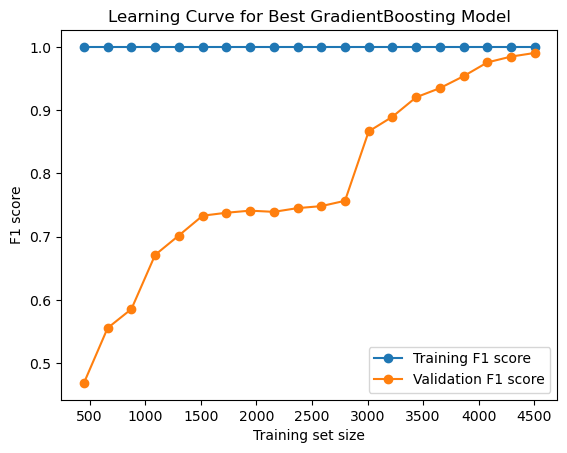

In [36]:
train_sizes, train_scores, valid_scores = learning_curve(
    best_model,
    X,
    y,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 20),
    verbose=2
)

train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, 'o-', label='Training F1 score')
plt.plot(train_sizes, valid_mean, 'o-', label='Validation F1 score')
plt.xlabel('Training set size')
plt.ylabel('F1 score')
plt.title('Learning Curve for Best GradientBoosting Model')
plt.legend()
plt.show()

The model's performance jumped drastically once the critical mass of around 3000 training size. In this moment, the model had enough info to improve a lot, until it reaches optimal performance.

In [37]:
from sklearn import set_config
set_config(display='diagram')
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'HourSpendOnApp',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'OrderAmountHikeFromlastYear',
                                                   'CouponUsed', 'OrderCount',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount']),
                                                 ('...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['PreferredLoginDevice',
                                                   'CityTier',
                                                   'PreferredPaymentMode',
                                                   'Gender',
                                                   'PreferredOrderCat',
                                                   'MaritalStatus',
                                                   'Complain'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.2, max_depth=6,
                                            min_samples_split=10,
                                            n_estimators=300))])

In [38]:
joblib.dump(best_model, '../model/gradient_boost_pipeline.pkl')
joblib.dump(best_model.named_steps['classifier'], '../model/gradient_boost_model.pkl')

['../model/gradient_boost_model.pkl']

### But what if we were wrong? What if Random Forest is capable enough to perform as well as Gradient Boosting?

After all, it is faster than Gradient Boosting. If the performance is the same, Random Forest is indeed preferred (given this data).

In [39]:
rf_param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ['sqrt', 'log2', None]
}

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X, y)

print("Best F1 score after tuning:", rf_grid.best_score_)
print("Best parameters:", rf_grid.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best F1 score after tuning: 0.9797729887282941
Best parameters: {'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}


In [40]:
rf_best_model = rf_grid.best_estimator_
rf_predictions = rf_best_model.predict(X_test)

print(classification_report(y_test, rf_predictions))

rf_cm = confusion_matrix(y_test, rf_predictions)
print("Confusion Matrix:\n", rf_cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1172
           1       1.00      1.00      1.00       236

    accuracy                           1.00      1408
   macro avg       1.00      1.00      1.00      1408
weighted avg       1.00      1.00      1.00      1408

Confusion Matrix:
 [[1172    0]
 [   0  236]]


Honestly, not bad. It performed 100% like Gradient Boosting on the test set. During training instead, the best F1 score for Random Forest is 0.977 against the 0.993 of the Gradient Boosting.

We'll save this model as well. Both can be reliably used for churn prediction.

In [41]:
joblib.dump(rf_best_model, '../model/random_forest_pipeline.pkl')
joblib.dump(rf_best_model.named_steps['classifier'], '../model/random_forest_model.pkl')

['../model/random_forest_model.pkl']

In the next notebook, we will explore how the company can reduce churning rates through model explainability.